#  Dog Breed Identification


#### Import Dependencies

In [1]:
from __future__ import division, print_function

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os, sys, random
from importlib import reload  # Python 3
import numpy as np
import shutil
from glob import glob
import pandas as pd
from copy import deepcopy
from IPython.display import FileLink
from PIL import Image
import tensorflow as tf
import imgaug as ia
from imgaug import augmenters as iaa
import cv2
from skimage import data
from skimage.transform import resize

In [2]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


#### Define Constants

This notebook assumes that the data has been broken out in a fairly specific way. Within the main storage directory, there should be test, train, valid, sample (for cases when trying things on a sample set is beneficial), and results directories. The test directory should be the unzipped contents of the test.zip supplied. The train directory should contain a subdirectory for each class (each breed in this case, there are 120) and the images from train.zip should use labels.csv to sort the images into these subdirectories. The valid directory will contain the validation set and so a sample from each training breed should be moved to the corresponding validation breed. The sample dir should contain train and valid subdirectories and each should contain a small sample from the main train and valid directories. The results directory will be empty for now and is just a place to save things like weights and submission files. For the validation set, i took the last 20% of files from each training directory.

In [3]:
SAMPLE_SUBMISSION = "sample_submission.csv"
ID_MAP = "labels.csv"

STORAGE_DIR = "/home/tyler/storage/dogbreed2/"
TEST_DIR = STORAGE_DIR + "test/"
TRAIN_DIR = STORAGE_DIR + "train/"
VAL_DIR = STORAGE_DIR + "valid/"

SAMPLE_DIR = STORAGE_DIR + "sample/"
SAMPLE_TRAIN = SAMPLE_DIR + "train/"
SAMPLE_VAL = SAMPLE_DIR + "valid/"

RESULTS_DIR = STORAGE_DIR + "results/"
RESULT_FILE = RESULTS_DIR + 'dogbreeds.csv'

#### Get Label Data
There are few times in which the labels and the number of labels (classes) will be needed, so I save them here before getting started with the model.

In [4]:
sample_submission = pd.read_csv(STORAGE_DIR + SAMPLE_SUBMISSION)
class_names = sample_submission.columns[1:].values
num_classes = len(class_names)
img_width = 299

#### Take Quick Look At Unmodified Data

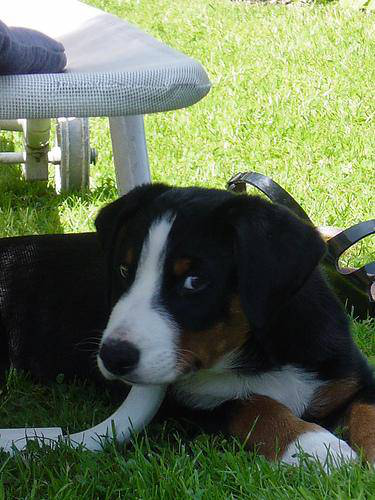

In [5]:
plot_dir = VAL_DIR + class_names[5] + "/"
filenames = os.listdir(plot_dir)

Image.open(plot_dir + filenames[5])

#### Define Model

I start by creating a basic InceptionV3 model from keras pretrained with imagenet weights. Note the input shape as 299x299 is optimized for InceptionV3 model.

In [6]:
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(img_width, img_width, 3)
)

#### Fine-Tune Pretrained Model

The pretrained models are built to recognize many objects, but this model needs to be specialized to predic based on 120 dog breeds, so some fine tuning has been done. Namely the logistic regression layer has been added to narrow it down to our 120 classes.

In [50]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy')


In [51]:
ia.seed(1)

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second
# image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image.
seq = iaa.Sequential(
    [
        #
        # Apply the following augmenters to most images.
        #
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images

        # crop some of the images by 0-10% of their height/width
        sometimes(iaa.Crop(percent=(0, 0.1))),

        # Apply affine transformations to some of the images
        # - scale to 80-120% of image height/width (each axis independently)
        # - translate by -20 to +20 relative to height/width (per axis)
        # - rotate by -45 to +45 degrees
        # - shear by -16 to +16 degrees
        # - order: use nearest neighbour or bilinear interpolation (fast)
        # - mode: use any available mode to fill newly created pixels
        #         see API or scikit-image for which modes are available
        # - cval: if the mode is constant, then use a random brightness
        #         for the newly created pixels (e.g. sometimes black,
        #         sometimes white)
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-45, 45),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),

        #
        # Execute 0 to 5 of the following (less important) augmenters per
        # image. Don't execute all of them, as that would often be way too
        # strong.
        #
        iaa.SomeOf((0, 5),
            [
                # Convert some images into their superpixel representation,
                # sample between 20 and 200 superpixels per image, but do
                # not replace all superpixels with their average, only
                # some of them (p_replace).
                sometimes(
                    iaa.Superpixels(
                        p_replace=(0, 1.0),
                        n_segments=(20, 200)
                    )
                ),

                # Blur each image with varying strength using
                # gaussian blur (sigma between 0 and 3.0),
                # average/uniform blur (kernel size between 2x2 and 7x7)
                # median blur (kernel size between 3x3 and 11x11).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),

                # Sharpen each image, overlay the result with the original
                # image using an alpha between 0 (no sharpening) and 1
                # (full sharpening effect).
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

                # Same as sharpen, but for an embossing effect.
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),

                # Search in some images either for all edges or for
                # directed edges. These edges are then marked in a black
                # and white image and overlayed with the original image
                # using an alpha of 0 to 0.7.
                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.7)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0, 0.7), direction=(0.0, 1.0)
                    ),
                ])),

                # Add gaussian noise to some images.
                # In 50% of these cases, the noise is randomly sampled per
                # channel and pixel.
                # In the other 50% of all cases it is sampled once per
                # pixel (i.e. brightness change).
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                ),

                # Either drop randomly 1 to 10% of all pixels (i.e. set
                # them to black) or drop them on an image with 2-5% percent
                # of the original size, leading to large dropped
                # rectangles.
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    ),
                ]),

                # Invert each image's chanell with 5% probability.
                # This sets each pixel value v to 255-v.
                iaa.Invert(0.05, per_channel=True), # invert color channels

                # Add a value of -10 to 10 to each pixel.
                iaa.Add((-10, 10), per_channel=0.5),

                # Change brightness of images (50-150% of original value).
                iaa.Multiply((0.5, 1.5), per_channel=0.5),

                # Improve or worsen the contrast of images.
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),

                # Convert each image to grayscale and then overlay the
                # result with the original with random alpha. I.e. remove
                # colors with varying strengths.
                iaa.Grayscale(alpha=(0.0, 1.0)),

                # In some images move pixels locally around (with random
                # strengths).
                sometimes(
                    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                ),

                # In some images distort local areas with varying strength.
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))
            ],
            # do all of the above augmentations in random order
            random_order=True
        )
    ],
    # do all of the above augmentations in random order
    random_order=True
)

#### Image Preprocessing

Next, create image data generators for image preprocessing, the only mandatory section is preprocessing_function using preprocess_input, each keras application (InceptionV3 in this case) has its own preprocessing_input function tuned for that model.

In [52]:
def train_preprocess(img):
    img = seq.augment_image(img)
    return img

train_datagen = image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = image.ImageDataGenerator(
    rescale=1./255
)


In [53]:
batch_size = 32
no_of_epochs = 100

#### Generate Train & Validation Batches

In [54]:
batches = train_datagen.flow_from_directory(
    TRAIN_DIR, 
    target_size=(img_width,img_width), 
    class_mode='categorical', 
    shuffle=True, 
    batch_size=batch_size
)

val_batches = test_datagen.flow_from_directory(
    VAL_DIR, 
    target_size=(img_width,img_width), 
    class_mode='categorical', 
    shuffle=False, 
    batch_size=batch_size
)

#keras 2 stuff
# batches.nb_class = batches.num_class
# batches.nb_sample = batches.samples

# val_batches.nb_class = batches.num_class
# val_batches.nb_sample = val_batches.samples

Found 8222 images belonging to 120 classes.
Found 2000 images belonging to 120 classes.


#### Check Batch Data

Check an image from the generated batches to make sure it looks ok

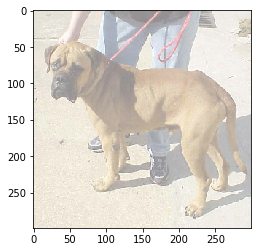

In [55]:
b1 = next(batches)[0][0]
b1 = (b1 + 1.)/2.
imgplot = plt.imshow(b1)

#### Train Model

Used some callbacks to reduce learning rate on plateau and save weights after every epoch that is an improvement on val-loss

In [56]:
checkpointer = ModelCheckpoint(filepath=RESULTS_DIR + "weights.hdf5", verbose=1, save_best_only=True)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
earlyStop = EarlyStopping(monitor='val_loss', patience=5)

with tf.device('/gpu:0'):
     model.fit_generator(
        batches,
        steps_per_epoch = int(np.ceil(float(batches.samples) / batch_size)),
        epochs=no_of_epochs,
        validation_data=val_batches,
        validation_steps = int(np.ceil(float(val_batches.samples) / batch_size)),
        callbacks=[checkpointer, reduceLR, earlyStop]
    )

Epoch 1/100
257/257 [==============================] - 152s - loss: 1.6974 - val_loss: 0.7629
Epoch 2/100
 29/257 [==>...........................] - ETA: 103s - loss: 0.7232

KeyboardInterrupt: 

#### Unfreeze Pretrained Layers
and recompile with sgd optimizer

In [65]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

#### Load Best Weights 
rather than use most recent weights

In [66]:
model.load_weights(RESULTS_DIR + "weights.hdf5")

#### Continue Training Full Model

In [67]:
checkpointer = ModelCheckpoint(filepath=RESULTS_DIR + "weights2.hdf5", verbose=1, save_best_only=True)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
earlyStop = EarlyStopping(monitor='val_loss', patience=5)

with tf.device('/gpu:0'):
     model.fit_generator(
        batches,
        steps_per_epoch = int(np.ceil(float(batches.samples) / batch_size)),
        epochs=no_of_epochs,
        validation_data=val_batches,
        validation_steps = int(np.ceil(float(val_batches.samples) / batch_size)),
        callbacks=[checkpointer, reduceLR, earlyStop]
    )

Epoch 1/100
  7/257 [..............................] - ETA: 852s - loss: 0.6709 - acc: 0.8125

KeyboardInterrupt: 

#### Generate Test Batches
this time only using the preprocess_input

In [58]:
test_batches = test_datagen.flow_from_directory(
    TEST_DIR, 
    target_size=(img_width,img_width), 
    class_mode=None, 
    shuffle=False, 
    batch_size=batch_size
)

Found 10357 images belonging to 1 classes.


#### Check Test Data

[[[[ 0.5411765   0.58823532  0.58039218]
   [ 0.58039218  0.62352943  0.60000002]
   [ 0.58823532  0.6156863   0.58431375]
   ..., 
   [ 0.627451    0.7019608   0.72549021]
   [ 0.58039218  0.65490198  0.67058825]
   [ 0.53725493  0.61176473  0.627451  ]]

  [[ 0.5529412   0.60000002  0.59215689]
   [ 0.59607846  0.63921571  0.62352943]
   [ 0.61176473  0.63921571  0.60784316]
   ..., 
   [ 0.62352943  0.69803923  0.72156864]
   [ 0.58823532  0.66274512  0.67843139]
   [ 0.54509807  0.61960787  0.63529414]]

  [[ 0.57647061  0.62352943  0.62352943]
   [ 0.62352943  0.66666669  0.65098041]
   [ 0.65098041  0.67843139  0.65098041]
   ..., 
   [ 0.61960787  0.69411767  0.71764708]
   [ 0.59607846  0.67058825  0.68627453]
   [ 0.5529412   0.627451    0.64313728]]

  ..., 
  [[ 0.97254908  0.90588242  0.83529419]
   [ 0.97647065  0.90980399  0.83921576]
   [ 0.98039222  0.91372555  0.84313732]
   ..., 
   [ 0.80000007  0.83529419  0.71372551]
   [ 0.76862752  0.81568635  0.65882355]
   [ 0.

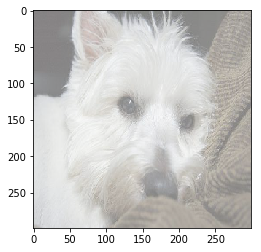

In [59]:
print(next(test_batches))
b2 = next(test_batches)[0]
b2 = (b2 + 1.)/2.
imgplot = plt.imshow(b2)

#### Generate Predictions

In [ ]:
model.load_weights(RESULTS_DIR + "weights2.hdf5")

In [60]:
preds = model.predict_generator(test_batches, int(np.ceil(float(test_batches.samples) / batch_size)))

#### Generate Kaggle Submission File

In [61]:
filenames = test_batches.filenames
ids = np.array([str(f[8:f.find('.')]) for f in filenames])

In [62]:
columns = sample_submission.columns.values
rows = []

for index, row in enumerate(preds):
    row = row.tolist()
    row.insert(0, ids[index])
    rows.append(row)

df = pd.DataFrame(rows, columns=columns)

In [63]:
df.to_csv(RESULT_FILE, sep=',', index=False)

In [64]:
%cd ~/notebooks/dogbreed
FileLink("dogbreeds.csv")

/home/tyler/notebooks/dogbreed


/home/tyler/notebooks/dogbreed/dogbreeds.csv